# TensorFlow Tutorial #11
# Adversarial Examples

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

In the previous tutorials, we have used various kinds of Deep Neural Networks for classifying images with varying success. In this tutorial we will see a simple method for finding so-called Adversarial Examples that cause a state-of-the-art neural network to mis-classify any input image to whatever class we choose. This is done simply by adding a small amount of 'specialized' noise to the input image. The changes are imperceptible to humans, but it fools the neural network.

This builds on the previous tutorials. You should be familiar with neural networks in general (e.g. Tutorial #01 and #02), and knowledge of the Inception model is also helpful (Tutorial #07).

## Flowchart

We will use the Inception model from Tutorial #07 and modify / hack the TensorFlow graph to find adversarial examples that cause the Inception model to mis-classify the input images.

In the flow-chart below, an image of Willy Wonka has some noise added and the result is used as input to the Inception model. The goal is to find the noise that makes the Inception mis-classify the image to our desired target-class, here chosen to be a 'bookcase' (class-number 300).

We have also added a new loss or cost-function to the graph, that calculates the so-called cross-entropy, which is a measure of how well the Inception model has performed at classifying the noisy image.

Because the Inception model is constructed from many basic mathematical operations that have been combined, TensorFlow allows us to easily find the gradient of the loss-function using the chain-rule of differentiation.

We use the gradient of the loss-function with regard to the input-image, to guide us when searching for the adversarial noise. We are looking for noise that increases the classification score (aka. probability) for 'bookcase' rather than the original classification of the input image.

This essentially performs optimization using gradient descent and is implemented further below.

In [1]:
from IPython.display import Image, display
Image('images/11_adversarial_examples_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Functions and classes for loading and using the Inception model.
import inception

/Users/jonathansherman/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'1.8.0'

## Inception Model

### Download the Inception model from the internet

The Inception model is downloaded from the internet. This is the default directory where you want to save the data-files. The directory will be created if it does not exist.

In [4]:
# inception.data_dir = 'inception/'

Download the data for the Inception model if it doesn't already exist in the directory. It is 85 MB.

In [5]:
inception.maybe_download()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


### Load the Inception Model

Load the Inception model so it is ready for classifying images.

Note the deprecation warning, which might cause the program to fail in the future.

In [6]:
model = inception.Inception()

### Get Input and Output for the Inception Model

Get a reference to the input tensor for the Inception model. This tensor is for the resized image, that is, the raw bytes for a 299 x 299 image with 3 colour channels. We will add noise to the resized image and feed the result back into the graph using this as well, so we make sure that the noise is not processed further by the resizing algorithm.

In [7]:
resized_image = model.resized_image

Get a reference to the output of the softmax-classifier for the Inception model.

In [8]:
y_pred = model.y_pred

Get a reference to the unscaled output of the softmax-classifier for the Inception model. These are often called 'logits'. The logits are necessary because we will add a new loss-function to the graph, which requires these unscaled outputs.

In [9]:
y_logits = model.y_logits

### Hack the Inception Model

In order to find adversarial examples we will need to add a new loss-function to the graph for the Inception model. We also need the gradient of this loss-function with regard to the input image.

In [10]:
# Set the graph for the Inception model as the default graph,
# so that all changes inside this with-block are done to that graph.
with model.graph.as_default():
    # Add a placeholder variable for the target class-number.
    # This will be set to e.g. 300 for the 'bookcase' class.
    pl_cls_target = tf.placeholder(dtype=tf.int32)

    # Add a new loss-function. This is the cross-entropy.
    # See Tutorial #01 for an explanation of cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])

    # Get the gradient for the loss-function with regard to
    # the resized input image.
    gradient = tf.gradients(loss, resized_image)
    print(tf.get_default_graph())

In [11]:
print(gradient)

[<tf.Tensor 'gradients/Sub_grad/Reshape:0' shape=(1, 299, 299, 3) dtype=float32>]


## TensorFlow Session

We need a TensorFlow session to execute the graph.

In [12]:
session = tf.Session(graph=model.graph)
print(tf.get_default_graph())

## Helper-function for finding Adversary Noise

The following function finds the noise that must be added to the given input image so as to be classified as the desired target-class.

This function essentially just performs optimization with gradient descent. The noise is initialized to zero and then iteratively updated using the gradient of the loss-function with regard to the noisy input image, so that in each step the noise brings the classification closer to the desired target-class. The optimization is terminated when the target-classification is reached with the required score (e.g. 99%), or when the max number of iterations have been performed.

In [13]:
def find_adversary_noise(image_path, cls_target, noise_limit=3.0,
                         required_score=0.99, max_iterations=100):
    """
    Find the noise that must be added to the given image so
    that it is classified as the target-class.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    max_iterations: Max number of optimization iterations to perform.
    """

    # Create a feed-dict with the image.
    feed_dict = model._create_feed_dict(image_path=image_path)

    # Use TensorFlow to calculate the predicted class-scores
    # (aka. probabilities) as well as the resized image.
    pred, image = session.run([y_pred, resized_image],
                              feed_dict=feed_dict)

    # Convert to one-dimensional array.
    pred = np.squeeze(pred)

    # Predicted class-number.
    cls_source = np.argmax(pred)

    # Score for the predicted class (aka. probability or confidence).
    score_source_org = pred.max()

    # Names for the source and target classes.
    name_source = model.name_lookup.cls_to_name(cls_source,
                                                only_first_name=True)
    name_target = model.name_lookup.cls_to_name(cls_target,
                                                only_first_name=True)

    # Initialize the noise to zero.
    noise = 0

    # Perform a number of optimization iterations to find
    # the noise that causes mis-classification of the input image.
    for i in range(max_iterations):
        print("Iteration:", i)

        # The noisy image is just the sum of the input image and noise.
        noisy_image = image + noise

        # Ensure the pixel-values of the noisy image are between
        # 0 and 255 like a real image. If we allowed pixel-values
        # outside this range then maybe the mis-classification would
        # be due to this 'illegal' input breaking the Inception model.
        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=255.0)

        # Create a feed-dict. This feeds the noisy image to the
        # tensor in the graph that holds the resized image, because
        # this is the final stage for inputting raw image data.
        # This also feeds the target class-number that we desire.
        feed_dict = {model.tensor_name_resized_image: noisy_image,
                     pl_cls_target: cls_target}

        # Calculate the predicted class-scores as well as the gradient.
        pred, grad = session.run([y_pred, gradient],
                                 feed_dict=feed_dict)

        # Convert the predicted class-scores to a one-dim array.
        pred = np.squeeze(pred)

        # The scores (probabilities) for the source and target classes.
        score_source = pred[cls_source]
        score_target = pred[cls_target]

        # Squeeze the dimensionality for the gradient-array.
        grad = np.array(grad).squeeze()

        # The gradient now tells us how much we need to change the
        # noisy input image in order to move the predicted class
        # closer to the desired target-class.

        # Calculate the max of the absolute gradient values.
        # This is used to calculate the step-size.
        grad_absmax = np.abs(grad).max()
        
        # If the gradient is very small then use a lower limit,
        # because we will use it as a divisor.
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10

        # Calculate the step-size for updating the image-noise.
        # This ensures that at least one pixel colour is changed by 7.
        # Recall that pixel colours can have 255 different values.
        # This step-size was found to give fast convergence.
        step_size = 7 / grad_absmax

        # Print the score etc. for the source-class.
        msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_source, cls_source, name_source))

        # Print the score etc. for the target-class.
        msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_target, cls_target, name_target))

        # Print statistics for the gradient.
        msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
        print(msg.format(grad.min(), grad.max(), step_size))

        # Newline.
        print()

        # If the score for the target-class is not high enough.
        if score_target < required_score:
            # Update the image-noise by subtracting the gradient
            # scaled by the step-size.
            noise -= step_size * grad

            # Ensure the noise is within the desired range.
            # This avoids distorting the image too much.
            noise = np.clip(a=noise,
                            a_min=-noise_limit,
                            a_max=noise_limit)
        else:
            # Abort the optimization because the score is high enough.
            break

    return image.squeeze(), noisy_image.squeeze(), noise, \
           name_source, name_target, \
           score_source, score_source_org, score_target

### Helper-function for plotting image and noise

This function normalizes the input so its values are between 0.0 and 1.0 which is needed to show the noise properly.

In [14]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

This function plots the original image, the noisy image, and the noise. It also shows the class-names and scores.

In [15]:
def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target):
    """
    Plot the image, the noisy image and the noise.
    Also shows the class-names and scores.

    Note that the noise is amplified to use the full range of
    colours, otherwise if the noise is very low it would be
    hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for finding and plotting adversarial example

This function combines the above two helper-functions. It first finds the adversarial noise and then plots the image with the noise.

In [16]:
def adversary_example(image_path, cls_target,
                      noise_limit, required_score):
    """
    Find and plot adversarial noise for the given image.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    """

    # Find the adversarial noise.
    image, noisy_image, noise, \
    name_source, name_target, \
    score_source, score_source_org, score_target = \
        find_adversary_noise(image_path=image_path,
                             cls_target=cls_target,
                             noise_limit=noise_limit,
                             required_score=required_score)

    # Plot the image and the noise.
    plot_images(image=image, noise=noise, noisy_image=noisy_image,
                name_source=name_source, name_target=name_target,
                score_source=score_source,
                score_source_org=score_source_org,
                score_target=score_target)

    # Print some statistics for the noise.
    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(),
                     noise.mean(), noise.std()))

## Results

### Parrot

This example takes an input image of a parrot and finds adversarial noise that causes the Inception model to mis-classify the image as a bookcase (class-number 300).

The noise-limit is set to 3.0 which means that each pixel-colour is only allowed to change by max &plusmn; 3.0. Each pixel-colour is a value between 0 and 255, so a change of &plusmn; 3.0 corresponds to only about 1.2% of the range of possible values. Such a small amount of noise is imperceptible to the human eye, so the noisy image looks exactly like the original image, as shown below.

The required-score is set to 0.99 which means the optimization that finds the adversarial noise will stop when the target classification score is 0.99 or higher, so the Inception model is almost completely certain that the noisy image shows the desired target class.

Iteration: 0
Source score:  97.52%, class-number:  409, class-name: macaw
Target score:   0.00%, class-number:  300, class-name: bookcase
Gradient min: -0.001649, max:  0.001400, stepsize:   4245.48

Iteration: 1
Source score:  85.86%, class-number:  409, class-name: macaw
Target score:   0.02%, class-number:  300, class-name: bookcase
Gradient min: -0.001501, max:  0.002324, stepsize:   3011.43

Iteration: 2
Source score:  69.13%, class-number:  409, class-name: macaw
Target score:   0.05%, class-number:  300, class-name: bookcase
Gradient min: -0.001618, max:  0.001187, stepsize:   4326.04

Iteration: 3
Source score:  25.89%, class-number:  409, class-name: macaw
Target score:   0.14%, class-number:  300, class-name: bookcase
Gradient min: -0.001093, max:  0.001030, stepsize:   6402.04

Iteration: 4
Source score:  16.69%, class-number:  409, class-name: macaw
Target score:   0.32%, class-number:  300, class-name: bookcase
Gradient min: -0.001008, max:  0.001124, stepsize:   6229.40



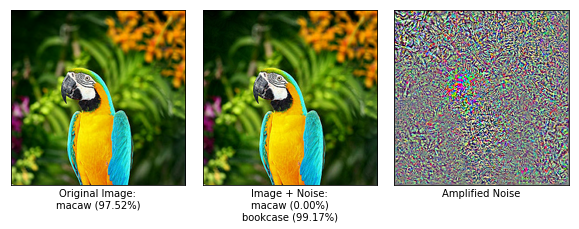

Noise min: -3.000, max: 3.000, mean: 0.001, std: 1.486


In [17]:
image_path = "images/parrot_cropped1.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

As shown above, the original image of the parrot looks exactly like the noisy image. The human eye cannot tell the difference between these two images. The original image is correctly classified by the Inception model as a macaw (i.e. parrot) with a score of 97.38%. But the noisy image has a classification score of 0.00% for macaw and 99.12% for a bookcase.

So we have fooled the Inception model into believing that an image of a parrot shows a bookcase. This mis-classification was achieved simply by adding a little 'specialized' noise.

Note that the noise shown above has been greatly amplified. In reality, the noise adjusts the colour intensity of each pixel in the input image by a maximum of 1.2% of the possible intensity range (assuming the noise-limit is set to 3.0 in the function above). Because the noise is so low, the change is imperceptible to humans, but it causes the Inception model to completely mis-classify the input image.

### Elon Musk

We can also find adversarial noise for an image of Elon Musk. The target-class is again set to a 'bookcase' (class-number 300), with the same settings for the noise-limit and required score as above.

Iteration: 0
Source score:  16.63%, class-number:  837, class-name: sweatshirt
Target score:   0.01%, class-number:  300, class-name: bookcase
Gradient min: -0.003983, max:  0.005454, stepsize:   1283.53

Iteration: 1
Source score:   2.21%, class-number:  837, class-name: sweatshirt
Target score:   0.31%, class-number:  300, class-name: bookcase
Gradient min: -0.005823, max:  0.006348, stepsize:   1102.73

Iteration: 2
Source score:   0.83%, class-number:  837, class-name: sweatshirt
Target score:   9.25%, class-number:  300, class-name: bookcase
Gradient min: -0.005701, max:  0.004797, stepsize:   1227.76

Iteration: 3
Source score:   0.26%, class-number:  837, class-name: sweatshirt
Target score:  68.26%, class-number:  300, class-name: bookcase
Gradient min: -0.001075, max:  0.001518, stepsize:   4611.54

Iteration: 4
Source score:   0.05%, class-number:  837, class-name: sweatshirt
Target score:  42.54%, class-number:  300, class-name: bookcase
Gradient min: -0.004382, max:  0.0035

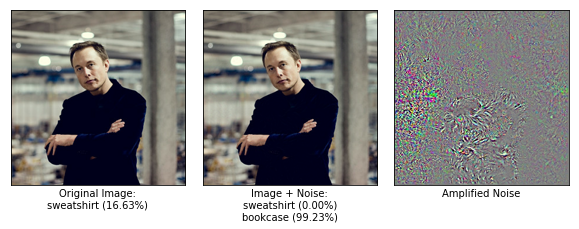

Noise min: -3.000, max: 3.000, mean: -0.000, std: 0.689


In [18]:
image_path = "images/elon_musk.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

The Inception model was confused about the classification of the original input image, classifying it as maybe a sweatshirt (score 19.73%). But we could still generate adversarial noise that made the Inception model almost completely certain that the noisy image shows a bookcase (score 99.09%), even though the two images seem to be exactly the same to the human eye.

## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources. Note that we have two TensorFlow-sessions, one is inside the model-object.

In [19]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()
# model.close()

## Conclusion

We have shown how to find so-called Adversarial Examples that cause the Inception model to mis-classify images. Through a simple optimization process, we find noise that can be added to an input image so as to cause the Inception model to mis-classify the image, even though each pixel has only been changed slightly and the difference is imperceptible to humans.

Furthermore, the noise can be optimized so as to give a score (aka. probability or confidence) of nearly 100%. So not only is the input image mis-classified, but the neural network is apparently very confident that it has correctly classified the image.

This is a general problem for neural networks and it is a very serious problem! Until we have a good understanding of why this happens and how to fix it, we cannot trust neural networks in critical applications. Imagine what would happen if a self-driving car ignores a stop-sign or a person crossing the road because its neural networks have mis-classified the input images.

Research into this problem is ongoing and you are encouraged to do an internet search for recent papers on the subject. Maybe you can find the solution to this problem?

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook and the other files before making any changes.

* Try using some of your own images.
* Try other arguments for `adversary_example()`. Try another target-class, noise-limit and required score. What is the result?
* Do you think it is possible to generate adversarial noise that would cause mis-classification for any desired target-class? How would you prove your theory?
* Try another formula for calculating the step-size in `find_adversary_noise()`. Can you make the optimization converge faster?
* Try blurring the noisy input-image right before it is input into the neural network. Does it remove the adversarial noise and cause correct classification again?
* Try lowering the bit-depth of the noisy input image instead of blurring it. Does it remove the adversarial noise and result in correct classification? For example if you only allow 16 or 32 colour-levels for Red, Green and Blue, whereas normally there are 255 levels.
* Do you think your noise-removal also works for hand-written digits in the MNIST data-set, or for strange geometric shapes? These are sometimes called 'fooling images', do an internet search.
* Can you find adversarial noise that would work for all images, so you don't have to find adversarial noise specifically for each image? How would you do this?
* Can you implement the optimization in `find_adversary_noise()` directly in TensorFlow instead of using NumPy? You would need to make the noise a variable in the TensorFlow graph as well, so it can be optimized by TensorFlow.
* Explain to a friend what Adversarial Examples are and how the program finds them.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.